In [1]:
import numpy as np
import pandas as pd
from actsnfink import *
from datetime import datetime
from astropy.time import Time
from myutils import loop_utils as lu
from myutils import plot_utils as pu
from myutils import data_utils as du


# Training all models but using the last non-detection if available as a limit

# Initial model

Model trained with 30 spectroscopically classified SNe light-curves. Using a subset of training set in Leoni et al. 2021

In [2]:
retrain_all_models = True
strategy = 'UncSampling'            # query strategy

In [10]:
# read train and test data
initial_train_for_loop = pd.read_csv( '../data/initial_state/' + strategy + \
                                           '/training_samples/train_after_loop.csv', 
                                           index_col=False)

test_for_loop = pd.read_csv('../data/initial_state/' + strategy + \
                                           '/test_samples/test_after_loop.csv', 
                                           index_col=False)

# select subset of test: only SNe
test_for_loop['type'].unique()
type_list = ['SN','SNII','Ia', 'SLSN-I','SNIIP', 'SNIIn', 'SLSN-II', 'SNIc', 'SNIb', 'SNIIb', 'SNI','SNIb-pec', 'SNIc-BL','SNII-pec','SNIbn']
test_for_loop = test_for_loop[test_for_loop['type'].isin(type_list)]


# train
lu.train_and_test_initial_model(initial_train_for_loop,test_for_loop,strategy)


Number of training light-curves 40
['accuracy 0.47', 'efficiency 0.26', 'purity 0.87', 'fom 0.18']


# Data

### TNS classifications within time-range of experiment

In [11]:
# read TNS labels
df_tns_w_ztfdata = du.load_TNS_reformat('../classifications/tns_fink_20230817.parquet')
df_tns_w_ztfdata_SSO = du.apply_timerange_fink_fup(df_tns_w_ztfdata, ndaysplus=9)
print(f"{len(df_tns_w_ztfdata_SSO)} TNS objects with ZTF data. {len(df_tns_w_ztfdata_SSO['discoveryjd'].unique())} unique dates. (not necessarily all have enough epochs for classification)")
dic_allTNS_labels = lu.convert_DF_dic_labels(df_tns_w_ztfdata_SSO)
print(f"TNS dictionary unique dates {len(dic_allTNS_labels.keys())}")

# classified by ZTF
ztf_tns = df_tns_w_ztfdata_SSO[df_tns_w_ztfdata_SSO['reporting_group']=='ZTF']
print(f"{len(ztf_tns)} ZTF detected. {len(ztf_tns['discoveryjd'].unique())} unique dates. (not necessarily all have enough epochs for classification)")
dic_ztf_labels = lu.convert_DF_dic_labels(ztf_tns)
print(f"ZTF dictionary unique dates {len(dic_ztf_labels.keys())}")


622 TNS objects with ZTF data. 137 unique dates. (not necessarily all have enough epochs for classification)
TNS dictionary unique dates 137
256 ZTF detected. 94 unique dates. (not necessarily all have enough epochs for classification)
ZTF dictionary unique dates 94


### Fink Siding Spring Observatory follow-up 
Fink programme to acquire labels for those candidates around P_Ia ~0.5

In [13]:
# read labels
df_Fink_AL = pd.read_csv('../classifications/ALbot_with_classifications_curated_original.tsv', sep='\t')

df_Fink_AL['fup requested'] = [Time(datetime.strptime(d[0], '%d/%m/%Y')).jd for d in df_Fink_AL[['Appears in bot']].values]
df_Fink_AL["fup requested (str)"] = df_Fink_AL.loc[:, "fup requested"].apply(
        lambda x: Time(x, format="jd").strftime("%Y%m%d")
    )
df_Fink_AL['label acquired'] = df_Fink_AL['fup requested'] + 1
# some of the Fink AL identified objects might have been classified by another group and reported to TNS
print(f"Adding {len(df_Fink_AL[df_Fink_AL['ztf_names'].isin(df_tns_w_ztfdata['ztf_names']) & df_Fink_AL['Classification'].isna()])} \
      classifications from TNS to Fink AL")

# Fill classification with TNS type if missing
to_merge = df_tns_w_ztfdata[['ztf_names', 'type AL']].rename(columns={'type AL':'ztf_type_AL'})
df_merged = pd.merge(df_Fink_AL, to_merge, how='left', on='ztf_names')
df_merged['Classification'] = df_merged.apply(lambda row: row.ztf_type_AL if row.Classification is None else row.Classification, axis=1)

# Drop the 'ztf_type_AL' column since it's now renamed
df_merged = df_merged.drop(columns=['ztf_type_AL'])
# keeep only those with classification
df_Fink_AL_w_classifications = df_merged[df_merged['Classification'].notna()]
df_Fink_AL_w_classifications.reset_index(drop=True, inplace=True)

# reformat type for AL loop
df_Fink_AL_w_classifications['type AL'] = df_Fink_AL_w_classifications.loc[:,'Classification'].apply(lambda x: 'Ia' if 'Ia' in x else 'other')

# sort
df_Fink_AL_w_classifications = df_Fink_AL_w_classifications.sort_values(by='fup requested')

# convert to AL format
new_labels = lu.convert_DF_dic_labels(df_Fink_AL_w_classifications)

Adding 0       classifications from TNS to Fink AL


In [14]:
if retrain_all_models:
    metrics_fink_all = lu.AL_loop(new_labels,strategy, test_for_loop, withlimits=True, dir_suffix ="FINK_wlimits", proba_cut = False, plot_lcs=True,verbose=True)
else:
    metrics_fink_all = pd.read_csv('../dump/data_fink_wlimits/metrics.csv')
    

## All ZTF reported classifications (from TNS)

In [16]:
if retrain_all_models:
    metrics_ztf = lu.AL_loop(dic_ztf_labels, strategy, test_for_loop, withlimits=True, dir_suffix='ZTF_wlimits', proba_cut = False,verbose=False, plot_lcs=True)
else:
    metrics_ztf = pd.read_csv('../dump/data_ZTF_wlimits/metrics.csv')

### all labels in literature with ZTF data


In [18]:
if retrain_all_models:
    metrics_allTNS = lu.AL_loop(dic_allTNS_labels, strategy, test_for_loop, withlimits=True, dir_suffix='TNS_wlimits', proba_cut = False,verbose=False, plot_lcs=True)
else:
    metrics_allTNS = pd.read_csv('../dump/data_TNS_wlimits/metrics.csv')


### Analysis

In [20]:
# date reformatting to align with all dates in our metrics
all_dates = np.concat([metrics_fink_all['date'].astype(int).values,metrics_allTNS['date'].astype(int).values, metrics_ztf['date'].astype(int).values])
all_dates = np.unique(all_dates)

# reformatting
metrics_fink_all['date'] = metrics_fink_all['date'].astype(int)
# lets put the date_plot in the same baseline using the combining dataset
to_merge = pd.DataFrame({'date':all_dates, 'date_plot_universal':np.arange(0,len(all_dates))})
metrics_fink_all_plot = pd.merge(metrics_fink_all, to_merge, on='date',how='left')
metrics_ztf['date'] = metrics_ztf['date'].astype(int)
metrics_ztf_plot = pd.merge(metrics_ztf, to_merge, on='date',how='left')
metrics_allTNS['date'] = metrics_allTNS['date'].astype(int)
metrics_allTNS_plot = pd.merge(metrics_allTNS, to_merge, on='date',how='left')

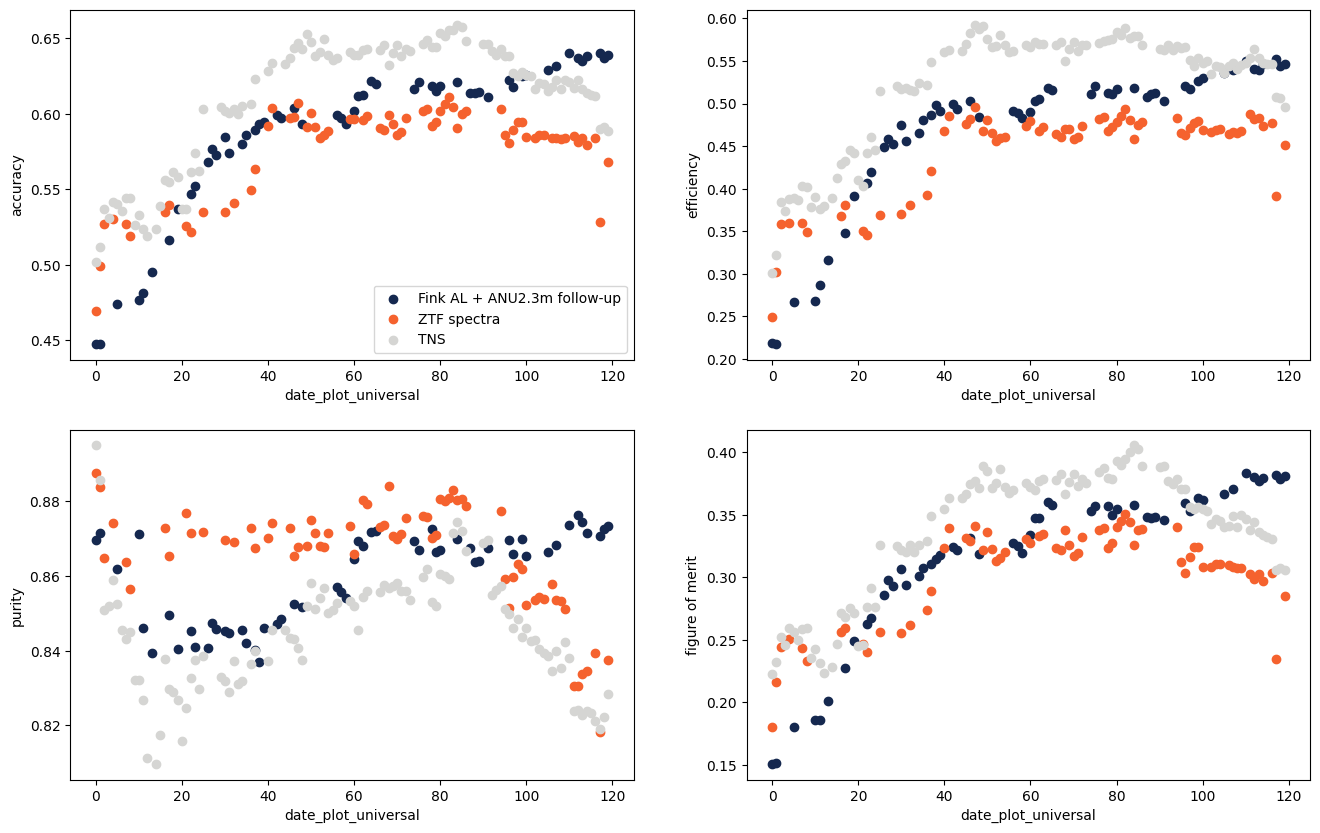

In [21]:
# not completely true as ZTF spectra dates are different than Fink AL ones
pu.plot_metrics_listdf([metrics_fink_all_plot,metrics_ztf_plot, metrics_allTNS_plot],['Fink AL + ANU2.3m follow-up','ZTF spectra', 'TNS'],varx='date_plot_universal', plots_dir = '../plots/')


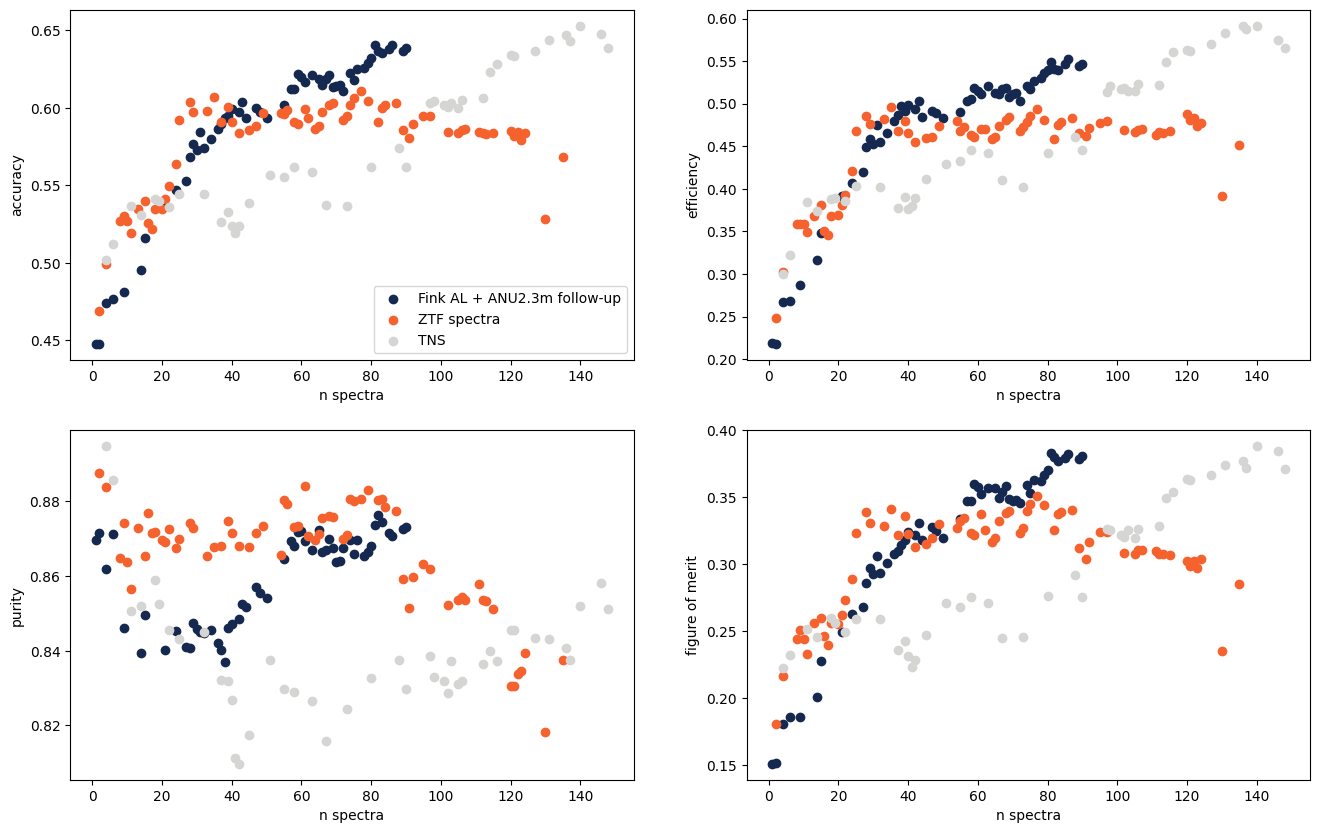

In [23]:
pu.plot_metrics_listdf([metrics_fink_all_plot,metrics_ztf_plot, metrics_allTNS_plot[metrics_allTNS_plot['n spectra']<150]],['Fink AL + ANU2.3m follow-up','ZTF spectra', 'TNS'],varx='n spectra', plots_dir = '../plots/')